# Salt segmentation

In this fifth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will implement a Convolutional Neural Network that can segment seismic data and extract salt bodies. For this example we will use the openly available dataset from the [TGS Kaggle Competition](https://www.kaggle.com/c/tgs-salt-identification-challenge).

More specifically, this notebook is organized as follows:

- XX

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn
import torchvision 

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from skimage import io
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torchvision.utils import make_grid
from torchvision import transforms
from torchsummary import summary

In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
def show_tensor_images(image_tensor, ax, num_images=25, vmin=-1, vmax=1):
    """Visualizing images

    Given a tensor of images, number of images, an size per image,
    plots and prints the images in an uniform grid.
    """
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5, normalize=False)
    ax.axis('off')
    ax.imshow(image_grid[0].squeeze(), cmap='gray', vmin=vmin, vmax=vmax)

In [4]:
# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

No GPU available!
Device: cpu


## Data retrieval

Let's start by loading the dataset, which is composed by pairs of images and masks. We are going to define a custom `Dataset` (see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) as well as apply some transformations (see https://pytorch.org/vision/stable/transforms.html).

In [5]:
class SaltDataset(Dataset):
    def __init__(self, imagedir, maskdir, files, transform=None, transformmask=None):
        self.imagedir = imagedir
        self.maskdir = maskdir
        self.transform = transform
        self.transformmask = transformmask
        self.total_imgs = files

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagedir, self.total_imgs[idx])
        mask_loc = os.path.join(self.maskdir, self.total_imgs[idx])
        image = io.imread(img_loc, as_gray=True).squeeze().astype(np.float32)
        mask = io.imread(mask_loc, as_gray=True).astype(np.float32).squeeze() / 65535.
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['mask'] = self.transformmask(sample['mask'])
        return sample

In [6]:
class DeMean(object):
    """Center mean around 0 and entire range between -1 and 1
    """
    def __init__(self):
        pass

    def __call__(self, image):
        image_mean = image.mean()
        image -= image_mean
        image_max = torch.abs(image).max()
        if image_max != 0:
            image = image / image_max
        return image
    
class Binarize(object):
    """Binarize mask (0 or 1)
    """
    def __init__(self):
        pass

    def __call__(self, image):
        image[image>0.5] = 1.
        image[image<=0.5] = 0.
        return image

In [7]:
datapath = '/Users/ravasim/Desktop/KAUST/Teaching/MLgeoscience/Exercises/SaltSegmentation/pytorch-saltnet/datasets'

# folder paths for images and masks
traindatapath = os.path.join(datapath, 'train', 'images')
trainmaskpath = os.path.join(datapath, 'train', 'masks')

# files
traindatafiles = os.listdir(traindatapath)[:64*20]
trainmaskfiles = os.listdir(trainmaskpath)[:64*20]

# define transform
transform = transforms.ToTensor()

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                DeMean()
                               ])
#transformaugment = transforms.Compose([transforms.ToTensor(), 
#                                       transforms.Resize((128, 128)),
#                                       DeMean(),
#                                       transforms.RandomHorizontalFlip(p=1)
#                                       ])
transformmask = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((128, 128)),
                                    Binarize()
                                   ])


# Create Dataset
train_dataset = SaltDataset(traindatapath, trainmaskpath, traindatafiles, transform=transform, transformmask=transformmask)

#train_dataset = \
#    ConcatDataset([SaltDataset(traindatapath, trainmaskpath, traindatafiles, transform=transform, transformmask=transformmask),
#                   SaltDataset(traindatapath, trainmaskpath, traindatafiles, transform=transformaugment, transformmask=transformmask)])
print(len(train_dataset))

# Create DataLoader
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #num_workers=0
# batch = next(iter(train_loader)) # nextbatch 

1280


"\n# Horizonally flipped data\nfig, axs = plt.subplots(2, ncols, figsize=(20, 4))\nfor i in range(ncols):\n    image, mask = train_dataset[4000+i]['image'][0], train_dataset[4000+i]['mask'][0]\n    axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)\n    axs[0, i].set_title('Sample #{}'.format(i))\n    axs[0, i].axis('off')\n    axs[1, i].imshow(mask, cmap='gray')\n    axs[1, i].axis('off')\n"

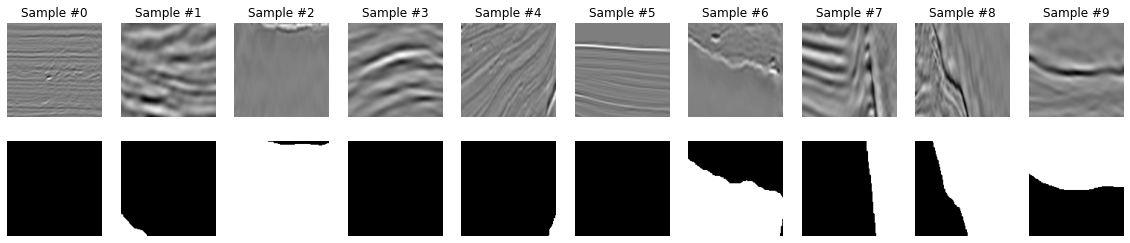

In [8]:
ncols = 10

fig, axs = plt.subplots(2, ncols, figsize=(20, 4))
for i in range(ncols):
    image, mask = train_dataset[i]['image'][0], train_dataset[i]['mask'][0]
    axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)
    axs[0, i].set_title('Sample #{}'.format(i))
    axs[0, i].axis('off')
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')

"""
# Horizonally flipped data
fig, axs = plt.subplots(2, ncols, figsize=(20, 4))
for i in range(ncols):
    image, mask = train_dataset[4000+i]['image'][0], train_dataset[4000+i]['mask'][0]
    axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)
    axs[0, i].set_title('Sample #{}'.format(i))
    axs[0, i].axis('off')
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')
"""

In [9]:
for batch in train_loader:
    X, y = batch['image'], batch['mask']
    print(np.sum(np.isnan(X.numpy())))
    print(np.sum(np.isnan(y.numpy())))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [10]:
# Check that image mean is 0 and max(abs)=1
batch = next(iter(train_loader))
torch.mean(batch['image'].view(64, 128*128), 1), torch.max(torch.abs(batch['image']).view(64, 128*128), 1)[0]

(tensor([ 5.7997e-08, -4.7898e-08,  1.6589e-08, -4.0622e-08,  1.9878e-08,
         -2.5939e-08, -2.7037e-08,  1.0405e-08,  3.9523e-08,  4.6915e-08,
          7.5161e-08, -4.4820e-09,  8.2800e-09, -5.5588e-09, -1.2806e-08,
         -1.0012e-08,  3.4634e-08,  7.5670e-09, -5.7822e-08, -1.2747e-08,
         -7.0359e-09, -2.4083e-08,  3.6409e-08, -1.3810e-08,  5.6985e-08,
         -2.8191e-08,  4.9651e-08,  9.2310e-08,  2.9977e-08,  1.1123e-07,
          4.7425e-08,  4.0018e-08, -7.1523e-09,  9.4005e-09, -4.1793e-08,
          5.8208e-09,  6.7084e-08,  5.0582e-08, -1.5483e-08, -2.9795e-08,
         -4.8152e-08,  2.5379e-08,  3.0312e-08,  6.2719e-09, -4.8200e-08,
          2.9511e-08,  4.0680e-08,  3.0210e-08,  3.2174e-08, -1.6356e-08,
          5.7538e-08,  1.4275e-08,  6.5484e-08, -4.5402e-09,  8.5973e-08,
         -4.3605e-08, -5.9605e-08, -3.6525e-08,  6.4218e-08,  5.7222e-08,
          3.3477e-08,  2.2497e-08,  5.4337e-08, -3.1796e-08]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [11]:
# Check mask
torch.max(torch.abs(batch['mask']).view(64, 128*128), 1)[0], np.unique(batch['mask'].numpy())

(tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
         1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 1.], dtype=float32))

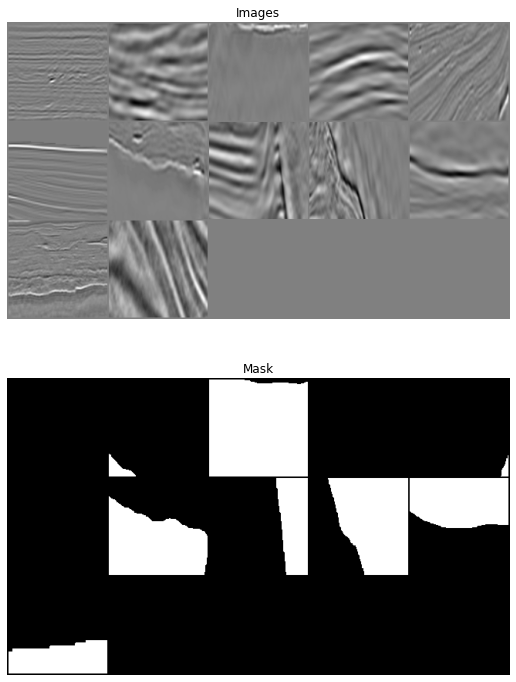

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(9, 12))
show_tensor_images(batch['image'], ax=axs[0], num_images=12, vmin=-1, vmax=1)
axs[0].set_title("Images")
axs[0].axis('tight')
show_tensor_images(batch['mask'], ax=axs[1], num_images=12, vmin=0, vmax=1)
axs[1].set_title("Mask")
axs[1].axis('tight');

## Training

In [13]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2) # nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=3, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2) # nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels=1, output_channels=1, hidden_channels=64):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=False)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=False)
        #self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=False)
        #self.contract4 = ContractingBlock(hidden_channels * 8)
        #self.contract5 = ContractingBlock(hidden_channels * 16)
        #self.contract6 = ContractingBlock(hidden_channels * 32)
        #self.expand0 = ExpandingBlock(hidden_channels * 64)
        #self.expand1 = ExpandingBlock(hidden_channels * 32)
        #self.expand2 = ExpandingBlock(hidden_channels * 16)
        #self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        #x3 = self.contract3(x2)
        #x4 = self.contract4(x3)
        #x5 = self.contract5(x4)
        #x6 = self.contract6(x5)
        #x7 = self.expand0(x6, x5)
        #x8 = self.expand1(x7, x4)
        #x9 = self.expand2(x8, x3)
        #x10 = self.expand3(x9, x2)
        x11 = self.expand4(x2, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.tanh(xn)

In [14]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

network = UNet(1, 1, hidden_channels=16).to(device)
#network = network.apply(weights_init)
print(network)
summary(network, input_size=(1, 128, 128))

UNet(
  (upfeature): FeatureMapBlock(
    (conv): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (contract1): ContractingBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): LeakyReLU(negative_slope=0.2)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contract2): ContractingBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): LeakyReLU(negative_slope=0.2)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (expand4): ExpandingBlock(
    (ups

In [15]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    accuracy = 0
    for dl in tqdm(data_loader):
        X, y = dl['image'], dl['mask']
        optimizer.zero_grad()
        yprob = model(X)
        loss = criterion(yprob, y)
        loss.backward()
        optimizer.step()
        y_pred = np.where(yprob[:, 0].detach().numpy() > 0.5, 1, 0)
        accuracy += accuracy_score(y.view(y.shape[0], y.shape[2]*y.shape[3]), 
                                   y_pred.reshape(y.shape[0], y.shape[2]*y.shape[3]))
    accuracy /= len(data_loader)
    fig, axs = plt.subplots(3, 1, figsize=(9, 12))
    show_tensor_images(X, ax=axs[0], num_images=12, vmin=-1, vmax=1)
    axs[0].set_title("Images")
    axs[0].axis('tight')
    show_tensor_images(y, ax=axs[1], num_images=12, vmin=0, vmax=1)
    axs[1].set_title("Mask")
    axs[1].axis('tight')
    show_tensor_images(yprob, ax=axs[2], num_images=12, vmin=0, vmax=1)
    axs[2].set_title("Reconstructed Mask")
    axs[2].axis('tight')
    plt.show()    
    return loss, accuracy


def evaluate(model, criterion, data_loader):
    model.eval()
    accuracy = 0
    for dl in data_loader:
        X, y = dl['image'], dl['mask']
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            yprob = model(X)
            loss = criterion(yprob, y)
        y_pred = np.where(yprob[:, 0].numpy() > 0.5, 1, 0)
        accuracy = accuracy_score(y.view(y.shape[0], y.shape[2]*y.shape[3]),
                                  y_pred.reshape(y.shape[0], y.shape[2]*y.shape[3]))
    accuracy /= len(data_loader)
    return loss, accuracy

In [16]:
set_seed(42)

n_epochs = 20
lr = 0.001

criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)#, weight_decay=1e-5)

  0%|          | 0/20 [00:00<?, ?it/s]

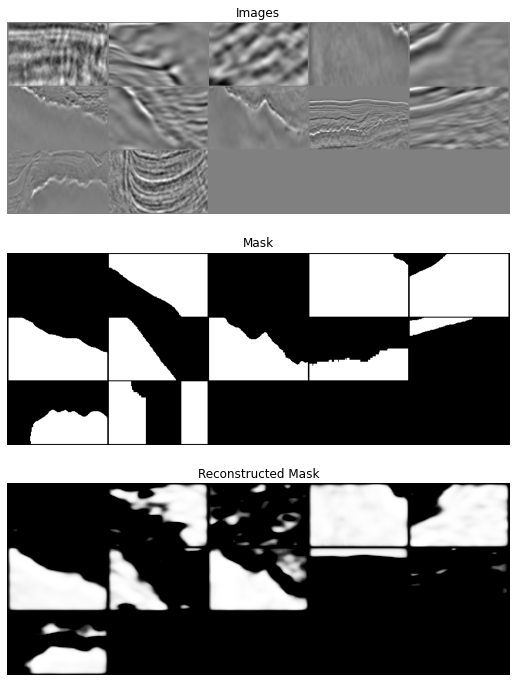

Epoch 0, Training Loss 0.53, Training Accuracy 0.11


  0%|          | 0/20 [00:00<?, ?it/s]

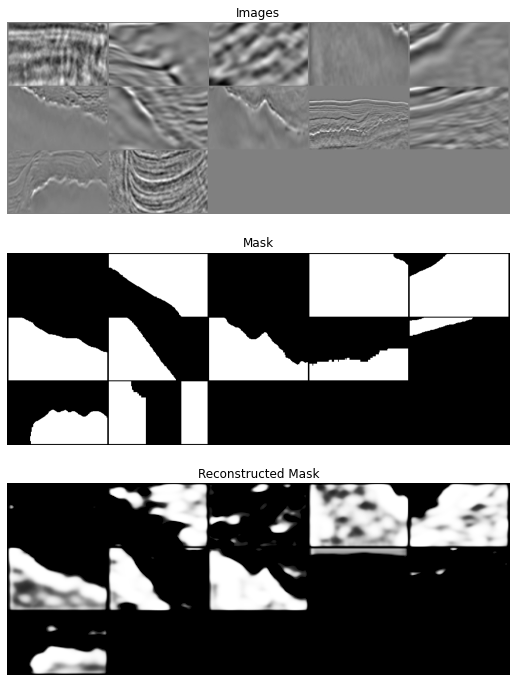

Epoch 1, Training Loss 0.49, Training Accuracy 0.22


  0%|          | 0/20 [00:00<?, ?it/s]

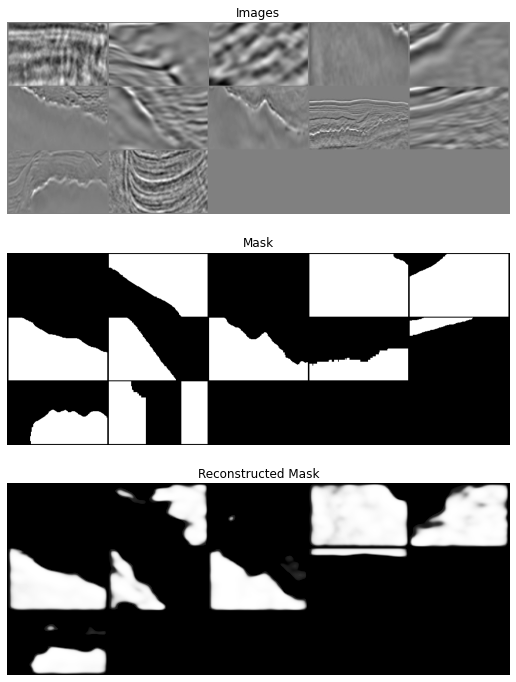

Epoch 2, Training Loss 0.49, Training Accuracy 0.27


  0%|          | 0/20 [00:00<?, ?it/s]

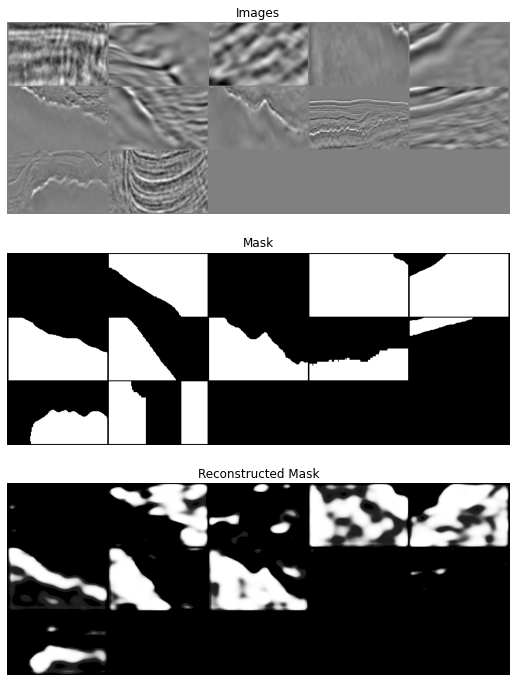

Epoch 3, Training Loss 0.48, Training Accuracy 0.23


  0%|          | 0/20 [00:00<?, ?it/s]

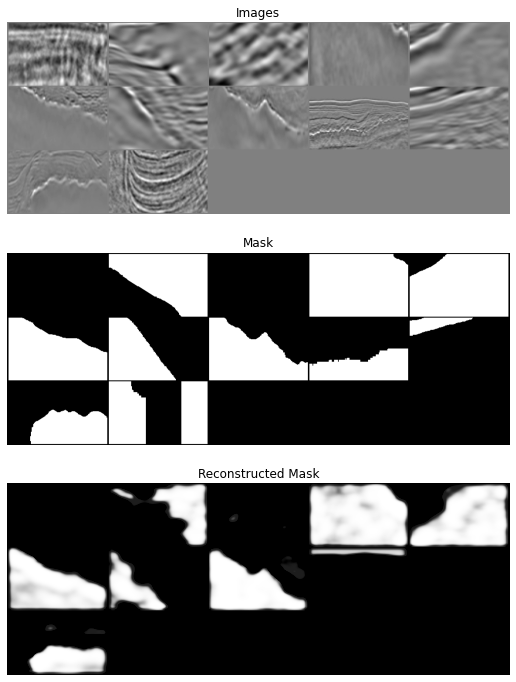

Epoch 4, Training Loss 0.47, Training Accuracy 0.24


  0%|          | 0/20 [00:00<?, ?it/s]

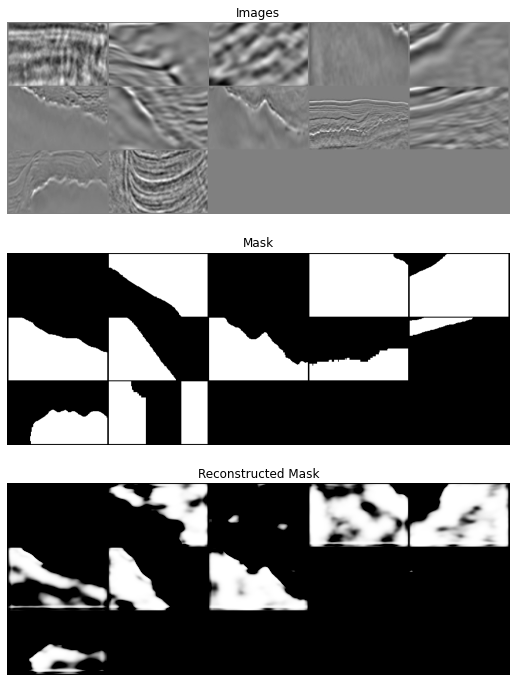

Epoch 5, Training Loss 0.45, Training Accuracy 0.28


  0%|          | 0/20 [00:00<?, ?it/s]

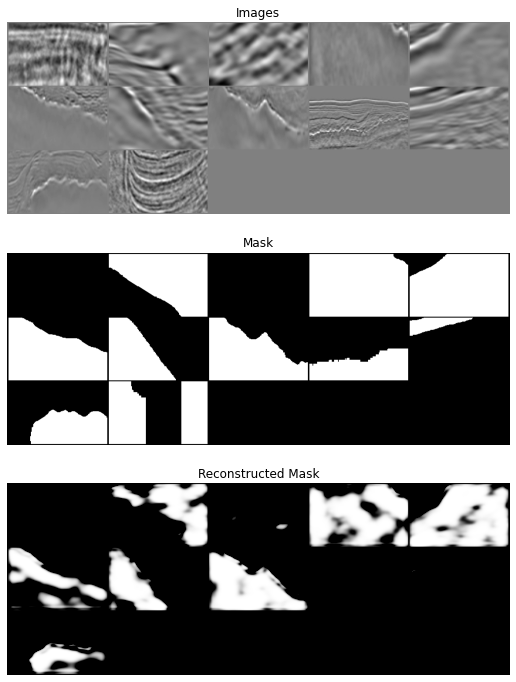

Epoch 6, Training Loss 0.46, Training Accuracy 0.24


  0%|          | 0/20 [00:00<?, ?it/s]

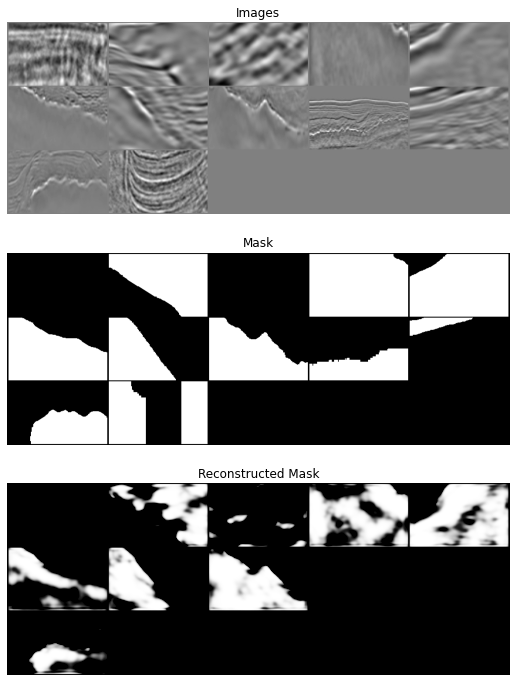

Epoch 7, Training Loss 0.45, Training Accuracy 0.26


  0%|          | 0/20 [00:00<?, ?it/s]

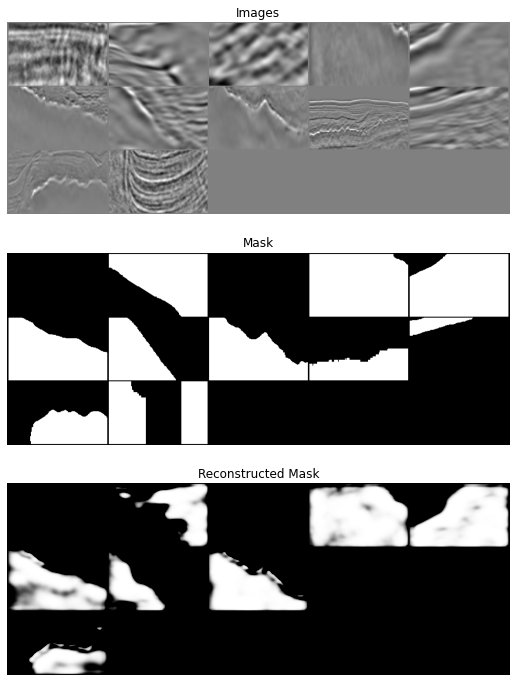

Epoch 8, Training Loss 0.44, Training Accuracy 0.25


  0%|          | 0/20 [00:00<?, ?it/s]

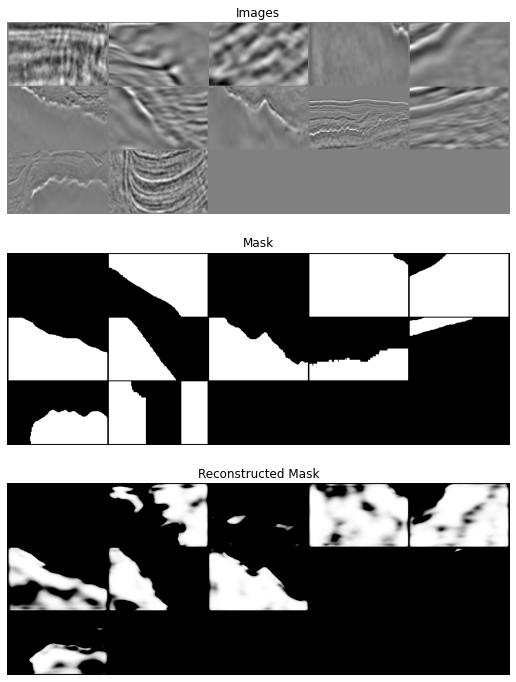

Epoch 9, Training Loss 0.43, Training Accuracy 0.27


In [17]:
epochs = 10
train_loss_history = np.zeros(epochs)
train_accuracy_history = np.zeros(epochs)
test_loss_history = np.zeros(epochs)
test_accuracy_history = np.zeros(epochs)

for i in range(epochs):
    train_loss, train_accuracy = train(network, criterion, optim, train_loader)
    #test_loss, test_accuracy = evaluate(network, criterion, test_loader)
    train_loss_history[i], train_accuracy_history[i] = train_loss, train_accuracy
    #if i % 100 == 0:
    print(f'Epoch {i}, Training Loss {train_loss.item():.2f}, Training Accuracy {train_accuracy:.2f}')#, Test Loss {test_loss.item():.2f}, Test Accuracy {test_accuracy:.2f}')